<ipython-input-2-cff38b4fc5d9>:19: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)
<ipython-input-2-cff38b4fc5d9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = pd.to_numeric(df['price'], errors='coerce')



Vehicle Age Distribution:
age
0.0      8937
1.0     11006
2.0     16336
3.0     15597
4.0     12675
5.0     12071
6.0     12550
7.0     14066
8.0     10822
9.0      9074
10.0     7145
11.0     5786
12.0     7970
13.0     6899
14.0     6237
15.0     5109
16.0     4349
17.0     3674
18.0     2835
19.0     2243
20.0     1739
21.0     1586
22.0     1037
23.0      892

Model Performance:
| Metric                | Value         |
|-----------------------|---------------|
| Min Age               | 0.0           |
| Max Age               | 23.0          |
| MAE                   | $3,847.27     |
| MSE                   | 27,753,878.18 |
| RMSE                  | $5,268.19     |
| R² Score              | 0.77          |
| MAPE                  | 33.79%        |
| Median Absolute Error | $2,775.01     |
| Explained Variance    | 0.77          |

Top 10 Important Features (Decision Tree):
| feature            |   importance_mean |   importance_std |
|--------------------|-------------------|---

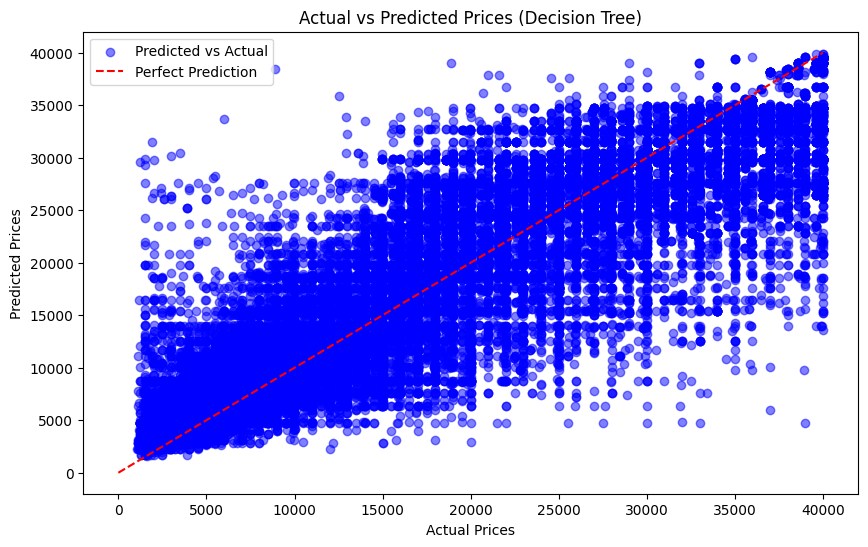

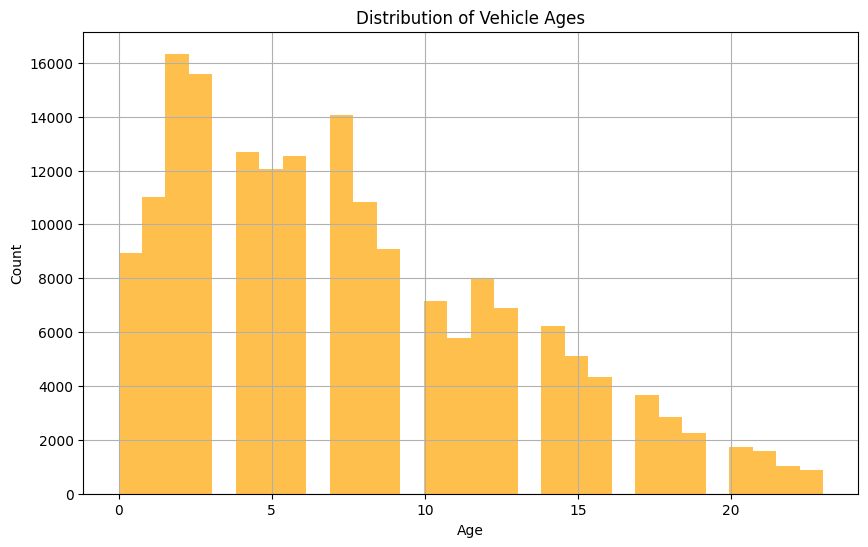

In [ ]:
# ========================== IMPORTS ==========================
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from tabulate import tabulate

# ========================== LOAD DATASET FROM KAGGLE ==========================
file_path = "vehicles.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)

# ========================== CLEANING ==========================
unused_cols = ['state','fuel','drive','manufacturer','cylinders','id', 'url', 'region', 'region_url',
               'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date']
df.drop(columns=unused_cols, inplace=True)

df = df[['price', 'year', 'condition', 'odometer', 'title_status', 'transmission', 'type']]
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(inplace=True)
df = df[(df['price'] > 1000) & (df['price'] <= 40000)]
df = df[(df['year'] >= 1997) & (df['year'] <= 2020)]

df['age'] = 2020 - df['year']
df.drop(columns='year', inplace=True)
df = pd.get_dummies(df, columns=['transmission', 'type', 'condition', 'title_status'], drop_first=True)

# ========================== SPLIT AND SCALE ==========================
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[['odometer']] = scaler.fit_transform(X_train[['odometer']])
X_test[['odometer']] = scaler.transform(X_test[['odometer']])

# ========================== DECISION TREE MODEL ==========================
model = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ========================== METRICS ==========================
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print("\nVehicle Age Distribution:")
print(df['age'].value_counts().sort_index().to_string())

print("\nModel Performance:")
print(tabulate([
    ['Min Age', df['age'].min()],
    ['Max Age', df['age'].max()],
    ['MAE', f"${mae:,.2f}"],
    ['MSE', f"{mse:,.2f}"],
    ['RMSE', f"${rmse:,.2f}"],
    ['R² Score', f"{r2:.2f}"],
    ['MAPE', f"{mape * 100:.2f}%"],
    ['Median Absolute Error', f"${medae:,.2f}"],
    ['Explained Variance', f"{evs:.2f}"]
], headers=['Metric', 'Value'], tablefmt='github'))

# ========================== PERMUTATION FEATURE IMPORTANCE ==========================
importance = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': importance.importances_mean,
    'importance_std': importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("\nTop 20 Important Features (Decision Tree):")
print(tabulate(importance_df.head(20), headers='keys', tablefmt='github', showindex=False))

# ========================== SAMPLE PREDICTION ==========================
sample_input = pd.DataFrame({
    'odometer': [45000],
    'age': [2020 - 2015],
    'transmission_manual': [0],
    'type_sedan': [1],
    'condition_good': [1],
    'title_status_clean': [1]
})
for col in X_train.columns:
    if col not in sample_input.columns:
        sample_input[col] = 0
sample_input = sample_input[X_train.columns]
sample_input[['odometer']] = scaler.transform(sample_input[['odometer']])

predicted_price = model.predict(sample_input)[0]
print(f"\nPredicted Price for sample input: ${predicted_price:,.2f}")

# ========================== PLOTS ==========================
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Decision Tree)')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='orange', alpha=0.7)
plt.title("Distribution of Vehicle Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
